# Preprocesamiento dataset

El conjunto de datos que se va a utilizar, proporcionado por Cam Nugent en Kaggle, contiene información histórica de precios de acciones para las 505 empresas que formaban parte del índice S&P 500 en el momento en el que se creó el dataset. Los datos abarcan un período de cinco años y están organizados en archivos CSV individuales para cada empresa y en un archivo CSV que contiene los datos de todas las empresas, que es el que se va a utilizar.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv("all_stocks_5yr.csv")

In [18]:
df.head(10)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL


In [19]:
df.shape

(619040, 7)

El dataset tiene 619.040 filas y 7 columnas. Tiene la siguiente estructura:

- **Date**: Fecha de la observación.
- **Open**: Precio de apertura.
- **High**: Precio máximo del día.
- **Low**: Precio mínimo del día.
- **Close**: Precio de cierre.
- **Volume**: Volumen de acciones negociadas.
- **Name**: Símbolo bursátil (Ticker) de la empresa.


In [20]:
unique_tickers = df["Name"].unique()
print(f"Número de empresas únicas en el dataset: {len(unique_tickers)}")

Número de empresas únicas en el dataset: 505


Al cargar el CSV, se carga como texto (object) la columna `date`, por lo que es necesario convertirla a formato datetime.

In [21]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


A continuación se ordena el dataset por empresa y fecha.

In [22]:
df = df.sort_values(by=['Name', 'date'])

Seguidamente, se observa si hay valores nulos o extremos en las columnas numéricas.

In [23]:
# Ver valores nulos
print(df.isnull().sum())

# Ver duplicados por combinación de fecha y empresa
duplicates = df.duplicated(subset=['date', 'Name'])
print(f"Número de duplicados por fecha y empresa: {duplicates.sum()}")


date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
Número de duplicados por fecha y empresa: 0


In [24]:
df.describe()


,date,open,high,low,close,volume
count,619040,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,2015-08-18 00:48:23.494443264,83.023334,83.778311,82.256096,83.043763,4.321823e+06
min,2013-02-08 00:00:00,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,2014-05-20 00:00:00,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,2015-08-21 00:00:00,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,2016-11-15 00:00:00,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2018-02-07 00:00:00,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08
std,NaN,97.378769,98.207519,96.507421,97.389748,8.693610e+06


Antes de rellenar los valores faltantes, se hizo un análisis estadístico general usando df.describe(), lo que permitió detectar algunos valores nulos en las columnas `open`, `high` y `low`. Aunque no son muchos, eliminarlos directamente no es buena idea porque también se perderían registros completos de ciertas fechas y empresas. Esto generaría huecos en las series temporales, lo que afectaría el cálculo de métricas importantes como los retornos diarios, la volatilidad o la correlación, fundamentales para los modelos de optimización de carteras.

Por eso, se decidió usar la técnica de **forward fill**, que consiste en rellenar los valores nulos con el último valor válido anterior. Este método es común en el análisis de datos financieros porque permite mantener la continuidad temporal de los datos sin introducir información artificial. Así se evita alterar el comportamiento natural del mercado y se garantiza que las series sean consistentes para cada empresa.

In [25]:
# Rellenar con forward fill
cols_to_fill = ['open', 'high', 'low']
df[cols_to_fill] = df.groupby('Name')[cols_to_fill].ffill()


In [26]:
# Verificar si aún quedan NaNs
nulls_remaining = df[cols_to_fill].isnull().sum()
if nulls_remaining.any():
  print("Advertencia: aún quedan NaNs después del forward fill:")
  print(nulls_remaining)

Advertencia: aún quedan NaNs después del forward fill:
open    2
high    2
low     2
dtype: int64


Después de hacer forward fill quedan dos valores nulos en cada columnas. Esto significa que están al principio de la serie temporal de alguna emrpesa, es decir, no hay ningún valor previo desde el que rellenar. Por ello se utiliza **bfill()**, que usa el primer valor conocido para rellenar el hueco anterior, lo cual es común y aceptado en análisis financiero puesto que no se está haciendo backtesting de estrategias históricas en tiempo real.

In [27]:
# Rellenar NaNs al principio después del ffill
df[cols_to_fill] = df.groupby('Name')[cols_to_fill].ffill().bfill()


In [28]:
print(df[cols_to_fill].isnull().sum())

open    0
high    0
low     0
dtype: int64


Existen valores extremos en algunas de las variables per no se eliminan porque hay acciones de empresas caras como AMZN o GOOG que históricamente tienen precios altos y válidos. Cortar el 1% superior eliminará datos legítimos de ese tipo de empresas, lo que introduciría sesgo, puede eliminar días con movimientos importantes (que son los que interesan para calcular riesgo y retorno), y distorsionan las estadísticas de volatilidad que son sensibles a extremos.

Por último, se elimina la columna `volume` puesto que no se utilizará en la creación de carteras de inversión posterior.

In [32]:
df_clean = df.drop(columns="volume")

In [33]:
df_clean.describe()

,date,open,high,low,close
count,619040,619040.000000,619040.000000,619040.000000,619040.000000
mean,2015-08-18 00:48:23.494443264,83.023824,83.778918,82.256663,83.043763
min,2013-02-08 00:00:00,1.620000,1.690000,1.500000,1.590000
25%,2014-05-20 00:00:00,40.220000,40.620000,39.830000,40.245000
50%,2015-08-21 00:00:00,62.590000,63.150000,62.020000,62.620000
75%,2016-11-15 00:00:00,94.370000,95.180000,93.540000,94.410000
max,2018-02-07 00:00:00,2044.000000,2067.990000,2035.110000,2049.000000
std,NaN,97.379720,98.208677,96.508493,97.389748


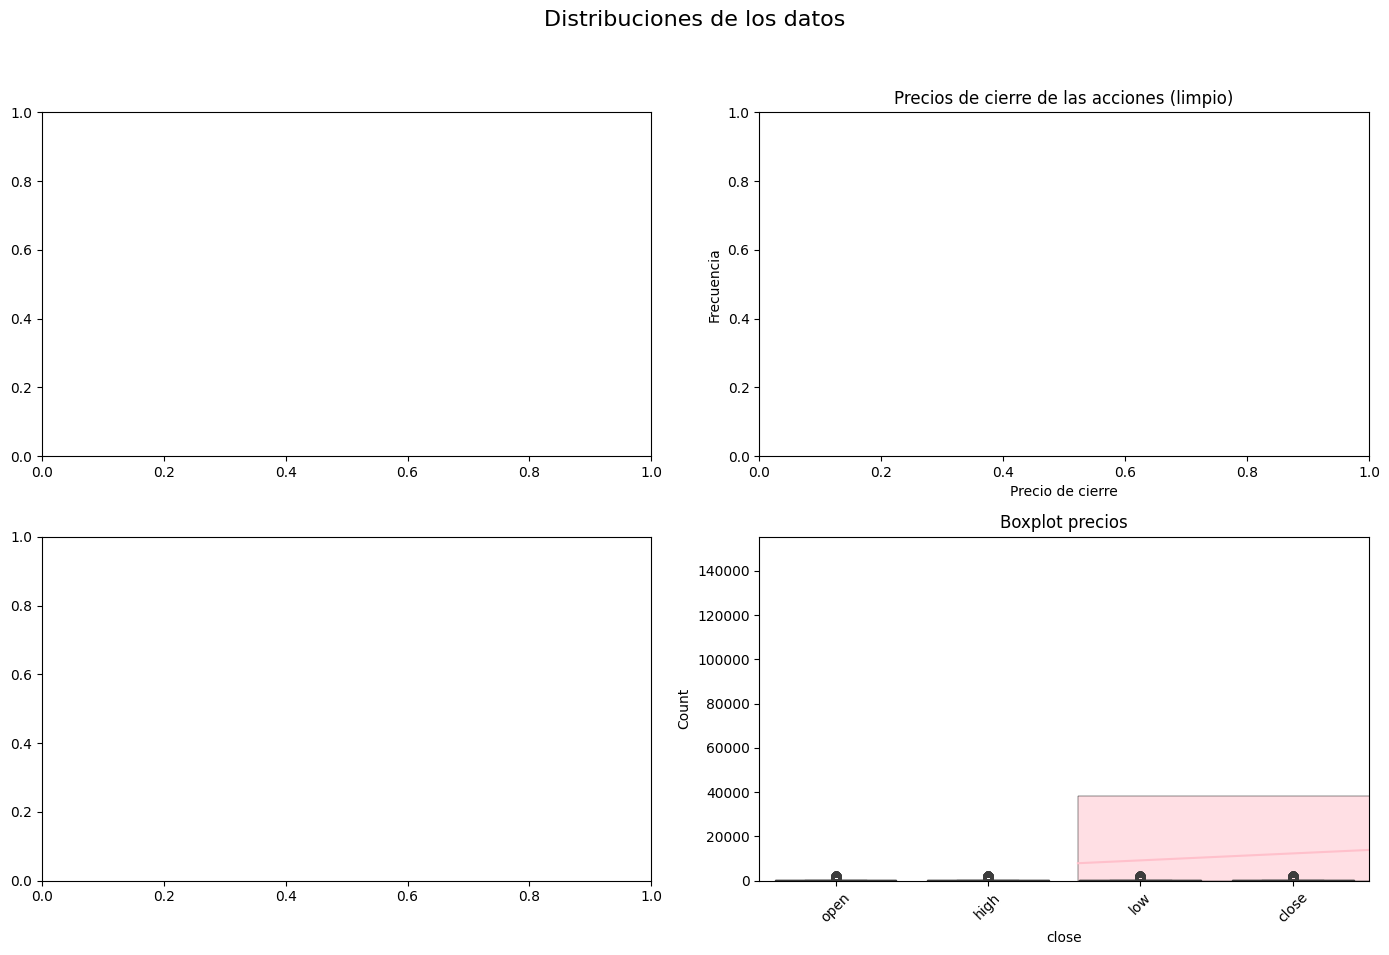

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Distribuciones de los datos", fontsize=16)

# Histograma de precios de cierre
sns.histplot(df_clean['close'], kde=True, bins=100, ax=axs[0, 1], color='pink')
axs[0, 1].set_title("Precios de cierre de las acciones (limpio)")
axs[0, 1].set_xlabel("Precio de cierre")
axs[0, 1].set_ylabel("Frecuencia")

# Boxplot de precios
sns.boxplot(data=df_clean[['open', 'high', 'low', 'close']], ax=axs[1, 1])
axs[1, 1].set_title("Boxplot precios")
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

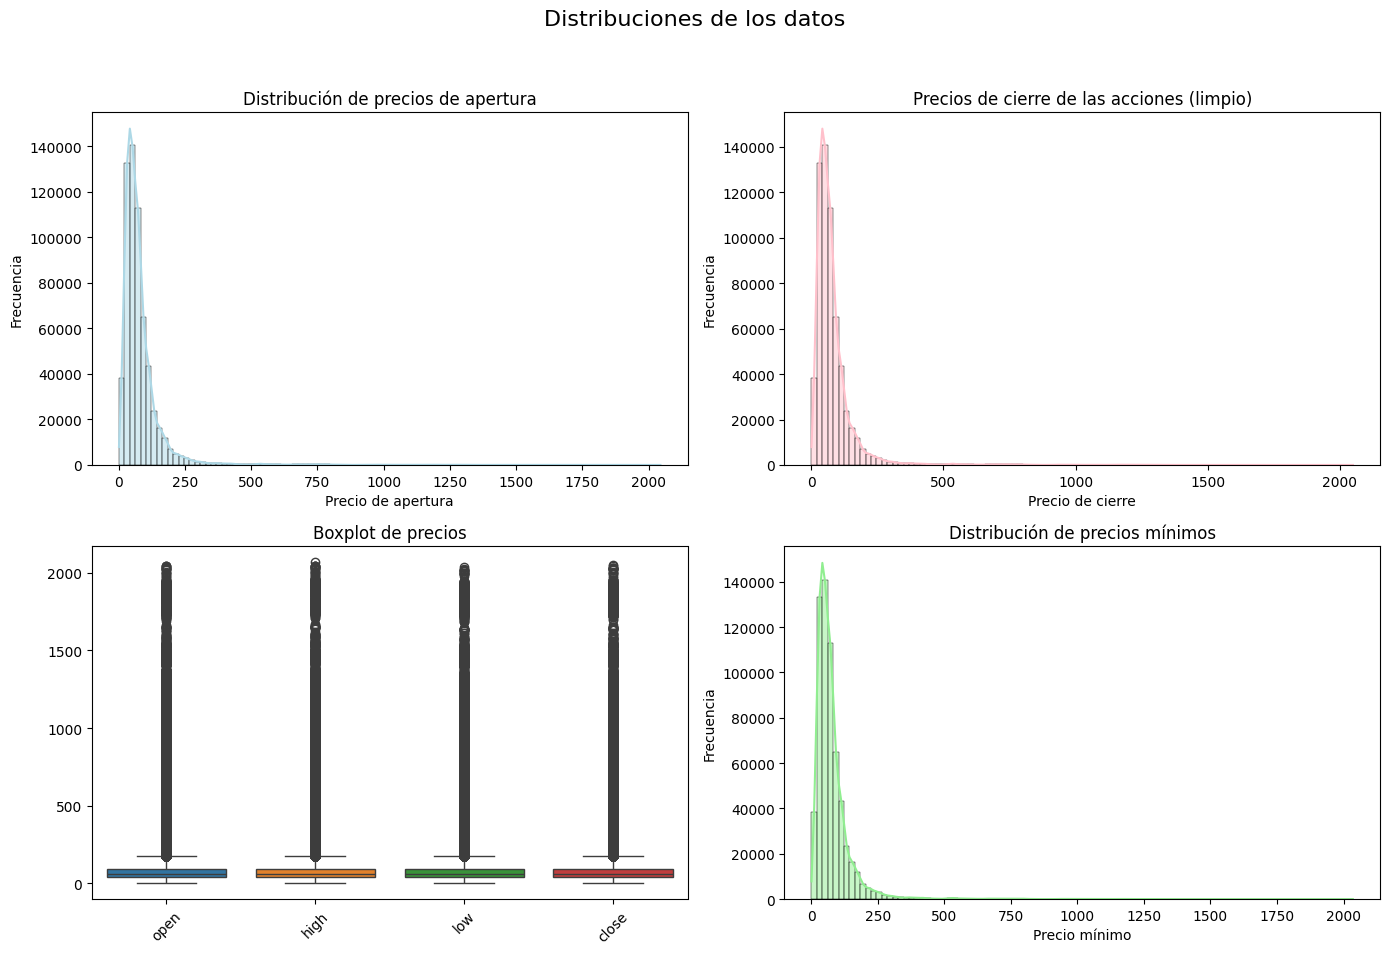

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear figura con 4 subplots (2x2)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Distribuciones de los datos", fontsize=16)

# Histograma de precios de apertura
sns.histplot(df_clean['open'], kde=True, bins=100, ax=axs[0, 0], color='lightblue')
axs[0, 0].set_title("Distribución de precios de apertura")
axs[0, 0].set_xlabel("Precio de apertura")
axs[0, 0].set_ylabel("Frecuencia")

# Histograma de precios de cierre
sns.histplot(df_clean['close'], kde=True, bins=100, ax=axs[0, 1], color='pink')
axs[0, 1].set_title("Precios de cierre de las acciones (limpio)")
axs[0, 1].set_xlabel("Precio de cierre")
axs[0, 1].set_ylabel("Frecuencia")

# Boxplot de precios
sns.boxplot(data=df_clean[['open', 'high', 'low', 'close']], ax=axs[1, 0])
axs[1, 0].set_title("Boxplot de precios")
axs[1, 0].tick_params(axis='x', rotation=45)

# Histograma de precios bajos
sns.histplot(df_clean['low'], kde=True, bins=100, ax=axs[1, 1], color='lightgreen')
axs[1, 1].set_title("Distribución de precios mínimos")
axs[1, 1].set_xlabel("Precio mínimo")
axs[1, 1].set_ylabel("Frecuencia")

# Ajustar layout evitando solapamiento con el título principal
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


A partir de las gráficas anteriores, se observa que las distribuciones de precios de apertura, cierre y mínimos presentan una fuerte asimetría hacia la derecha, con una alta concentración de valores en rangos bajos y un número reducido de observaciones con precios elevados. Este comportamiento es común en datos financieros y refleja la coexistencia de empresas con diferentes niveles de capitalización y liquidez.

El boxplot permite visualizar de forma clara esta disparidad, mostrando una gran cantidad de valores atípicos por encima del tercer cuartil en todas las variables (`open`, `high`, `low`, `close`). A pesar de ello, la forma general de las distribuciones es coherente entre sí, lo que confirma la consistencia interna de las series de precios utilizadas.

In [34]:
# Guardar el dataset preprocesado
df_clean.to_csv("stocks_cleaned.csv", index=False)